In [1]:
import matplotlib.pyplot as plt

# from config import settings

%matplotlib inline
import pandas as pd

import yaml


# db = pymongo.MongoClient("mongodb://localhost:27017/")['Jan16_cloudseg_saliency_loss']
# db = pymongo.MongoClient("mongodb://localhost:27017/")['Sep10_encoding']

# from joblib import Parallel, delayed, Memory

# mem = Memory('/tank/kuntai/joblib_cache',verbose=0)



plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 35
plt.rcParams['pdf.fonttype'] = 42
colors = [
    '#004DAF',
    '#ED1B3A',
    '#FF9900',
    '#33A02C',
    '#FABEAF',
    '#AAD59B'
]
bandwidth = 10 * 1000 * 1000 / 8 # 10 Mbps
inference = 0.05
latency = 0.03 # 30ms network latency

def savefig(filename, fig):
    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fig.savefig(f'{filename}_time_{timestr}.pdf', bbox_inches='tight')
    fig.savefig(f'{filename}.pdf', bbox_inches='tight')


In [2]:

def read_approach(name):
    with open(name, 'r') as f:
        x = pd.DataFrame.from_dict(yaml.load(f.read()))
        x = x.groupby(['second', 'input']).last().reset_index()
        # x = x[(x.input == "/dataheart/dataset/downtown/downtown_1/part%d.mp4") |
        #       (x.input == "/dataheart/dataset/downtown/downtown_3/part%d.mp4") |
        #       (x.input == "/dataheart/dataset/downtown/downtown_5/part%d.mp4") |
        #       (x.input == "/dataheart/dataset/downtown/downtown_7/part%d.mp4") |
        #       (x.input == "/dataheart/dataset/downtown/downtown_9/part%d.mp4")]
        print(len(x))
        return x

oneadapt = {}
# "oneadapt_encoding_8.999999999999999e-05_lr_0.5.yaml"
# stats/oneadapt_encoding_1e-05_lr_0.5.yaml
for idx, i in enumerate(["oneadapt_encoding_1e-05_lr_0.5.yaml","oneadapt_encoding_1.25e-05_lr_0.5.yaml","oneadapt_encoding_2.9999999999999997e-05_lr_0.5.yaml",]):
    oneadapt[idx] = read_approach(f'/dataheart/kuntai_recovery/code/diff_yitian/stats/{i}')
    
# chameleon2 = {}
# for i in [0.0125,0.05,0.2,0.8,2.4]:
#     chameleon2[i] = read_approach(f'/dataheart/kuntai_recovery/code/diff_yitian/stats/immediate_chameleon_2x_bwweight_{i}.yaml')

# chameleon2={}  
# for i in [0.0125,0.05,0.2]:
#     chameleon2[i] = read_approach(f'/dataheart/kuntai_recovery/code/diff_yitian/stats/chameleon_2x_bwweight_{i}.yaml')

    
chameleon3 = {}
for i in [0.05,0.2]:
    chameleon3[i] = read_approach(f'/dataheart/kuntai_recovery/code/diff_yitian/stats/chameleon_3x_bwweight_{i}.yaml')
    

casva = {}
for i in [0.0125,0.05,0.2]:
    casva[i] = read_approach(f'/dataheart/kuntai_recovery/code/diff_yitian/stats/casva_2x_bwweight_{i}.yaml')
    

awstream = {}
for i in [0.0125,0.05,0.2]:
    awstream[i] = read_approach(f'/dataheart/kuntai_recovery/code/diff_yitian/stats/awstream_3x_bwweight_{i}.yaml')

/dataheart/kuntai_recovery/envs/diff/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


1190
1190
1190
1190
1190
1190
1190
1190
1190
1190
1190


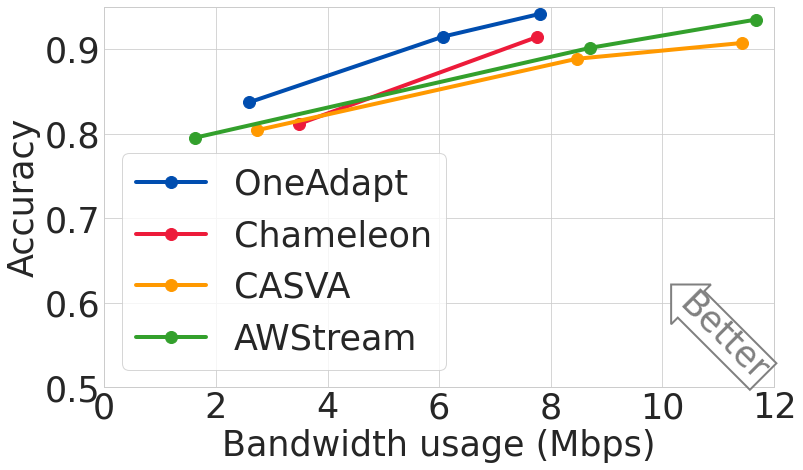

In [3]:


import numpy as np
# fmt = '/dataheart/dataset/rural/rural_1/part%d.mp4'
# v_list = [v_list[0]]

fig, ax = plt.subplots(figsize=(12, 7))

def make_plot(ax,d,c,l):
    # delta = 0.45 if 'OneAdapt' in l else 0
    key = sorted(d.keys())
    ax.plot([d[i].bandwidth.mean() * 8 / 1e6 for i in key], [d[i].f1.mean() for i in key],c=c, marker='o', linewidth=4, markersize=12,label=l)
    

make_plot(ax, oneadapt, colors[0], 'OneAdapt')
make_plot(ax, chameleon3, colors[1], 'Chameleon')
make_plot(ax, casva, colors[2], 'CASVA')
make_plot(ax, awstream, colors[3], 'AWStream')
ax.set_xlim(left=0)
# make_plot(ax, reducto, colors[2], 'Reducto')



# ax.plot([oneadapt_new[i].compute.mean() for i in [0.1,1.0,10]], [oneadapt_new[i].f1.mean() for i in [0.1,1.0,10]],c=colors[0], marker='o', linewidth=4, markersize=12)
# ax.plot([oneadapt[i].compute.mean() for i in [0.8,1.0,1.2]], [oneadapt[i].f1.mean() for i in [0.8,1.0,1.2]],c=colors[1], marker='o', linewidth=4, markersize=12)
# ax.set_xlim(left=0)

# ax.plot([oneadapt_new[i].bandwidth.mean() for i in oneadapt_new], [oneadapt_new[i].f1.mean() for i in oneadapt_new],c=colors[0], marker='o', linewidth=4, markersize=12)
# ax.plot([oneadapt[i].compute.mean() for i in [0.8,1.0,1.2]], [oneadapt[i].f1.mean() for i in [0.8,1.0,1.2]],c=colors[1], marker='o', linewidth=4, markersize=12)

ax.set_xlim(left=0)

l, r = 0, 12
b, u = 0.5, 0.95

ax.set_xlim(l,r)
ax.set_ylim(b,u)
ax.set_xlim(left=0)


ax.set_xlabel('Bandwidth usage (Mbps)')
ax.set_ylabel('Accuracy')

bbox_props = dict(boxstyle="larrow", fc=(1,1,1), ec="grey", lw=2)
t = ax.text(r,b, "Better", ha="right", va="bottom", rotation=-45,
            bbox=bbox_props, c='grey')

bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.05)

ax.legend(loc=3,frameon=True)

In [20]:
savefig('/home/kuntai/paper/OneAdapt-SIGCOMM-23/figs/bw-usage-RGB-encoding', fig)

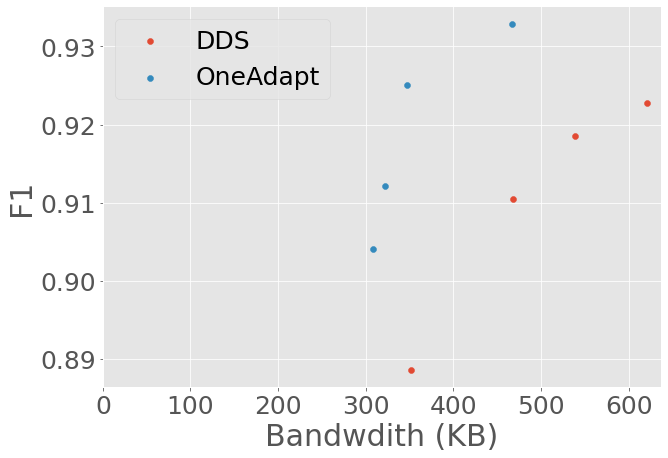

In [10]:
 

import numpy as np
fmt = '/dataheart/dataset/downtown/downtown_0/part%d.mp4'
def query_approach(fmt, approach="", column='stats'):
    stats = []


    for sec in range(0, 180):

        query = {
            'my_args.second': sec,
            'my_args.command_line_args.approach': approach,
            'my_args.input': fmt,
        }
        
        # if isinstance(approach, dict):
        #     del query['command_line_args.approach']
        #     query['input'] = query['command_line_args.input']
        #     del query['command_line_args.input']
        #     query.update(approach)
        #     print(query)

        x = list(db['examine'].find(query))
        x = sorted(x, key = lambda x: x['_id'])
        stats.append(x[-1])

    return np.mean([i['my_video_config']['bw'] for i in stats]), np.mean([i['f1'] for i in stats])
    # ax[1].plot(range(len(f1s)), [i['f1'] for i in f1s], label=label)
    

fig, ax = plt.subplots(figsize=(10, 7))





x = []


import numpy as np
fmt = '/dataheart/dataset/downtown/downtown_0/part%d.mp4'
def query_approach(fmt, approach="", column='stats'):
    stats = []


    for sec in range(0, 180):

        query = {
            'my_args.second': sec,
            'my_args.command_line_args.approach': approach,
            'my_args.input': fmt,
        }
        
        # if isinstance(approach, dict):
        #     del query['command_line_args.approach']
        #     query['input'] = query['command_line_args.input']
        #     del query['command_line_args.input']
        #     query.update(approach)
        #     print(query)

        x = list(db['examine'].find(query))
        x = sorted(x, key = lambda x: x['_id'])
        stats.append(x[-1])

    return np.mean([i['my_video_config']['bw'] for i in stats]), np.mean([i['f1'] for i in stats])
    # ax[1].plot(range(len(f1s)), [i['f1'] for i in f1s], label=label)
    

fig, ax = plt.subplots(figsize=(10, 7))





x = []
for lq in [32, 30, 28, 36]:

    y = []

    for idx in range(10):
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'
        y.append(query_approach(fmt, f"dds_lq_{lq}"))
    y = np.array(y)

    x.append(np.mean(y, axis=0))
    
ax.scatter([i[0] / 1000 for i in x], [i[1] for i in x], label='DDS')


x=[]
for thresh in [0.00625,0.0125, 0.05, 0.2]:
    
    y = []

    
    for idx in range(10):
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'

        y.append(query_approach(fmt, f'oneadapt_macroblock_thresh_{thresh}'))
    y = np.array(y)

    x.append(np.mean(y, axis=0))
ax.scatter([i[0] / 1000 for i in x], [i[1] for i in x], label='OneAdapt')


ax.set_xlabel('Bandwdith (KB)')
ax.set_ylabel('F1')
ax.set_xlim(left=0)

    y = []

    for idx in range(1):
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'
        y.append(query_approach(fmt, f"dds_lq_{lq}"))
    y = np.array(y)

    x.append(np.mean(y, axis=0))
    
ax.scatter([i[0] / 1000 for i in x], [i[1] for i in x], label='DDS')


x=[]
for thresh in [0.00625,0.0125, 0.05, 0.2]:
    
    y = []

    
    for idx in range(1):
        fmt = f'/dataheart/dataset/downtown/downtown_{idx}/part%d.mp4'

        y.append(query_approach(fmt, f'oneadapt_macroblock_thresh_{thresh}'))
    y = np.array(y)

    x.append(np.mean(y, axis=0))
ax.scatter([i[0] / 1000 for i in x], [i[1] for i in x], label='OneAdapt')


ax.set_xlabel('Bandwdith (KB)')
ax.set_ylabel('F1')
ax.set_xlim(left=0)
ax.legend()

0.0648665301529331 0.7293657311274729
0.08506145258921027 0.789334231188738


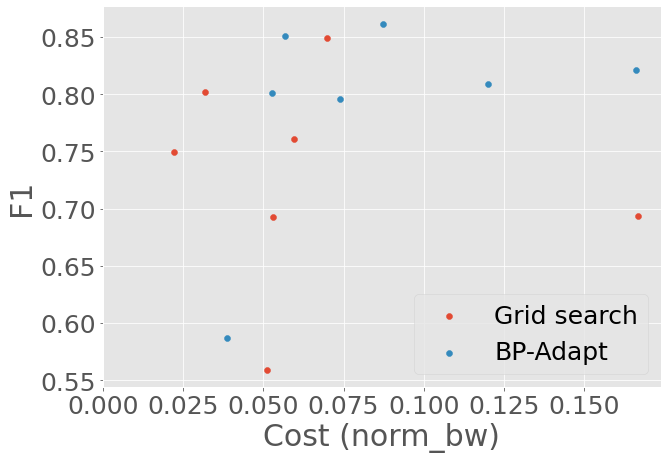

In [9]:
def calc_cost_chameleon(approach, fmt, cost_key='compute'):
    
    costs = []

    try:

        for sec in range(0, 1000):

            if sec < 9:
                continue

            query = {
                'second': sec,
                'command_line_args.approach': approach,
                'command_line_args.input': fmt,
            }

            x = list(db['cost'].find(query))
            x = sorted(x, key = lambda x: x['_id'])
            costs.append(x[-1])

    except IndexError:
        pass
    
    return np.mean([i[cost_key] for i in costs])

def calc_cost_backprop(approach, fmt, cost_key='compute'):
    
    costs = []

    try:

        for sec in range(0, 1000):

            if sec < 9:
                continue
            
            query = {
                'second': sec,
                'command_line_args.approach': approach,
                'command_line_args.input': fmt,
            }

            x = list(db['stats'].find(query))
            x = sorted(x, key = lambda x: x['_id'])
            costs.append(x[-1])
            
            if sec % 3 == 0 and sec < 20:
                costs[-1]['compute'] = len(costs[-1]['encoded_frames']) / 10 + 0.1
            else:
                costs[-1]['compute'] = len(costs[-1]['encoded_frames']) / 10

    except IndexError:
        pass
    
    return np.mean([i[cost_key] for i in costs])

fig, ax = plt.subplots(figsize=(10, 7))

compute, bw, acc = [], [], []
for idx, fmt in enumerate(fmts):
    if idx == 2:
        continue
    compute.append(calc_cost_chameleon('chameleon', fmt))
    bw.append(calc_cost_chameleon('chameleon', fmt, cost_key = 'norm_bw'))
    acc.append(calc_cost_chameleon('chameleon', fmt, cost_key = 'f1'))

ax.scatter([j for i,j in zip(bw, compute)], acc, label='Grid search')

print(np.mean([j for i,j in zip(bw, compute)]), np.mean(acc))


compute, bw, acc = [], [], []
for idx, fmt in enumerate(fmts):
    if idx == 2:
        continue
    compute.append(calc_cost_backprop(approach1, fmt))
    bw.append(calc_cost_backprop(approach1, fmt, cost_key='norm_bw'))
    acc.append(calc_cost_backprop(approach1, fmt, cost_key='f1'))

ax.scatter([j for i,j in zip(bw, compute)], acc, label='BP-Adapt')
print(np.mean([j for i,j in zip(bw, compute)]), np.mean(acc))

ax.set_xlim(left=0)
ax.set_xlabel('Cost (norm_bw)')
ax.set_ylabel('F1')

ax.legend()